In [1]:
from twitch import commons
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import preprocessing
import numpy as np

from sklearn import decomposition
from sklearn.manifold import TSNE
import scipy
%pylab inline

import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large'}

pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


## Classifying User Chat Logs using BoW Model

In [2]:
users_df = pd.read_csv('./user_chat_counts.csv.dat', header=None, names=['user', 'total', 'male', 'female'])
users_df = users_df[users_df.total >= 100]

In [3]:
chat_messages = {line.split(',')[0]:line.split(',')[1] for line in open("./user_all_message.csv.dat", 'r')}

In [4]:
users_df = users_df[users_df.user.isin(chat_messages.keys())]
users_df['female_chat_percentage'] = (users_df.female*100)/users_df.total
users_df['chat_log'] = users_df.user.apply(lambda x : chat_messages[x])

In [5]:
users_df.shape

(77027, 6)

In [6]:
users_df = users_df[(users_df.female_chat_percentage == 100) | (users_df.female_chat_percentage == 0)]

In [7]:
users_df.shape

(35588, 6)

In [8]:
y = np.array([1 if x > 50 else 0 for x in users_df.female_chat_percentage.values.tolist()])

In [9]:
tf = TfidfVectorizer(analyzer='word', max_features=100000, stop_words = 'english')

In [10]:
x = tf.fit_transform(users_df.chat_log.values.tolist())
x = preprocessing.normalize(x)
feature_names = tf.get_feature_names()

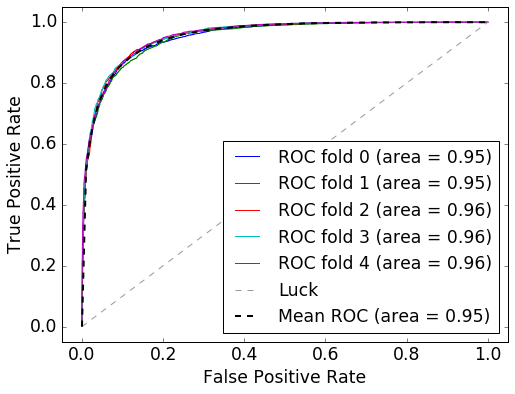

Accuracy: 0.88 (+/- 0.01)


In [11]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

clf,coef,_ = commons.build_lr_classification_model_cv(x, y, 5)

In [12]:
print('Female words : ' + ', '.join([feature_names[i] for i in coef[0].argsort()[-25:][::-1]]))
print('')
print('Male words : ' + ', '.join([feature_names[i] for i in (- coef[0]).argsort()[-25:][::-1]]))

Female words : boobs, kitty, cute, cat, dizzy, hair, beautiful, draw, ally, shy, sky, amy, scare, ign, tits, wishes, dolly, drawing, queen, date, pineapples, pixels, diego, sing, fruit

Male words : beard, nelson, boogie, core, amp, sp, smash, dm, nl, rom, sketch, hawk, sick, gassy, phil, shadow, spoon, trick, cop, pixel, cab, nickel, loyalty, spam, max


In [13]:
type(x)

scipy.sparse.csr.csr_matrix

## Clustering the document vectors

In [14]:
with open('tsne-users.dat') as fp:
    tsne_users_sample = fp.read().splitlines()

In [15]:
def delete_row_csr(mat, i):
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    n = mat.indptr[i+1] - mat.indptr[i]
    if n > 0:
        mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
        mat.data = mat.data[:-n]
        mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
        mat.indices = mat.indices[:-n]
    mat.indptr[i:-1] = mat.indptr[i+1:]
    mat.indptr[i:] -= n
    mat.indptr = mat.indptr[:-1]
    mat._shape = (mat._shape[0]-1, mat._shape[1])

In [16]:
sample_size = len(tsne_users_sample)
female_chat_percentages = users_df.female_chat_percentage.values.tolist()
percentages = []
deleted_count = 0
for i,user in enumerate(users_df.user.values.tolist()):
    if user not in tsne_users_sample:
        delete_row_csr(x, i - deleted_count)
        deleted_count += 1
        percentages.append(female_chat_percentages[i])

In [17]:
print(x.shape)

(10000, 13331)


In [ ]:
pca = decomposition.TruncatedSVD(n_components = 100)
pca.fit(x)
feature_vectors = pca.fit_transform(x)

In [ ]:
doc_xy_vectors = TSNE(n_components=2, verbose=2).fit_transform(feature_vectors)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.110566
[t-SNE] Iteration 25: error = 1.2435595, gradient norm = 0.0009765
[t-SNE] Iteration 25: gradient norm 0.000977. Finished.
[t-SNE] Iteration 50: error = 1.2094070, gradient norm = 0.0033346
[t-SNE] Iteration 75: error 

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size

colors = ['#63c17e' if percentages[i] >= 50 else '#1F1F1F' for i in range(0,10000)]

plt.scatter([x[0] for x in doc_xy_vectors],
            [y[1] for y in doc_xy_vectors],
            s=32, color=colors, lw=1, alpha=0.6)

plt.scatter([0], [0], s=32, color='#63c17e' , lw=1, label='female streamer only users', alpha=0.6)
 
plt.scatter([0], [1], s=32, color='#1F1F1F', lw=1, label='male streamer only users', alpha=0.6)
             
plt.xlim(xmin=-12, xmax=12)
plt.ylim(ymin=-12, ymax=12)

plt.legend(loc='lower left')
savefig('user_clusters.png')